In [1]:
import matplotlib.pyplot as mp

In [2]:
from math import pi,cos,sqrt
import numpy as np
import scipy.linalg
import cvxpy as cp

In [ ]:
def loopar(y,trm,non,sigma):
    mu = 0
    for i in range(non):
        bas = random.gauss(mu, sigma)
        y.append(autor(y[i:i+len(trm)],trm) + bas)
    return y

def autor(x,trm):
    y = 0
    for i in range(len(trm)):
        try:
            y = y + x[i]*trm[i]
        except IndexError:
            return y
    return y

In [3]:

#### ISSUES:
# orignal program does not work with missing values dispite what title says 
# what does ./ mean?

def froweightold(L,K):
    N=L+K-1
    w = []
    for i in range(1,L-1):
        w.append(i)
    for i in range(L,K):
        w.append(L)
    for i in range(K+1,N):
        w.append(N-i+1)
    return w
    

def hmat(vec,vert):
    """
    hmat Hankel matrix from a vector "vec"

    """
    hoz = 1 + len(vec) - vert
    col = []
    for i in range(vert):
        row = np.array([])
        for j in range(hoz):
            row = np.append(row, vec[i + j,])
        col.append(row)
    return np.array(col)

def create_data(N,sigma):
    s = []
    for n in range(N):
        s.append(cos(2*pi*n/10)+3) # case 1
        #s(n)=cos(2*pi*n/10)*exp(0.02*n) # case 2
    r=sigma*np.random.uniform(0,1,N) 
    Y=s+r#.transpose()
    return Y


def hankvec_avg(X):
    """
    hankvec Perform diagonal averaging 
    """
    L,K = X.shape
    Xbase = np.append(X,np.zeros(K*K))
    bmat = Xbase[K:].reshape((K+L-1), K)
    y = []
    fws = froweights(K,L)
    print(bmat.shape,len(fws))
    for i in range(bmat.shape[0]):
        y.append(sum(bmat[i,:])/fws[i])
    return np.array(y)

def lra(X,r):
    [U,S,V2]= scipy.linalg.svd(X,full_matrices=False) # U,S,V] = SVD(X,"econ") produces the "economy size"
    S2 = S*np.identity(len(S))
    for i in range(r,len(S)):
        S2[i,i] = 0 #add 0s and the end for forcasting - replace by a mask instead?
    print(U.shape,S2.shape,S.shape,V2.shape)
    return np.matmul(U,np.matmul(S2,V2))#

def mcwf(Y,L,M,w,e):
    """
    Weighted vectors with forecast
    """
    N=len(w)
    e = 1.07
    x = N+m
    Yapp = cp.Variable(x)
    objective = cp.Minimize(cp.normNuc(cphanker(Yapp[:L],Yapp[L:N])))
    constraints = [cp.norm(cp.matmul(cp.sqrt(w),(Y[:N]-Yapp[:N]))) <= e]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return result,Yapp
    
def mcw(Y,L,w,e):
    """
    Weighted vectors
    """
    N=len(Y);
    #cvx_begin sdp;
    #%cvx_solver mosek;
    #%cvx_precision low;
    Yapp = cp.Variable(N);
    objective = cp.Minimize(cp.normNuc(cphanker(Yapp[:L],Yapp[L:N])))
    constraints = [cp.norm(cp.sqrt(w) @ (Y-Yapp)) <=e] 
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return result

def wvnorm(y,w):
    """
    wvnorm Compute weighted vector norm given a vector y and a 
    vector of weights w
    """
    tot = []
    for i in range(len(w)):
        tot.append(w[i]*(y[i]**2))
    return sum(tot)

def froweights(L,K):
    N=L+K-1
    w = []
    for i in range(1,L-1):
        w = hyperpend(w,i,i)
    for i in range(L,K):
        w = hyperpend(w,L,i)
    for i in range(K,N):
        w = hyperpend(w,N-i+1,i)
    return np.array(w)

def hyperpend(vec,a,pos):
    try:
        vec[pos] = a
    except IndexError:
        vec.append(a)
    return vec

def hanker(row,reman):
    hank = []
    xi = row.shape[0]
    for i in range(xi):
        hank.append(np.append(row[:xi-i],reman[1:xi+i+1]))
    return np.array(hank)

def cphanker(row,reman):
    hank = []
    xi = row.shape[0]
    for i in range(xi):
        hank.append(np.append(row[:xi-i],reman[1:xi+i+1]))
    return cp.bmat(hank)

In [4]:
def mcwf(Y,L,M,w,e):
    """
    Weighted vectors with forecast
    """
    N=len(w)
    x = N+M
    Yapp = cp.Variable(x)
    objective = cp.Minimize(cp.normNuc(cphanker(Yapp[:L],Yapp[L:N])))
    constraints = [cp.norm((Y[:N]-Yapp[:N]) @ cp.sqrt(w)) <= e]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return Yapp.value#,prob

In [5]:
def mcwf2(Y,L,M,w,e):
    """
    Weighted vectors with forecast
    """
    N=len(Y)
    x = N+M
    Yapp = cp.Variable(N)
    objective = cp.Minimize(cp.normNuc(cphanker(Yapp[:L],Yapp[L:N])))
    constraints = [cp.norm((Y[:]-Yapp[:])) <= e]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return Yapp.value#,prob

In [8]:
N = 50
Y = create_data(N,0.1)
N_sim=1
L=10
k=2
m = 7
last = len(Y)-m
X=hmat(Y[:last],L)
wF=froweights(L,X.shape[1])
wUnit=np.ones(N-m)
wExp = []
for i in range(1,N-m):
    wExp.append(1.03**i)
wExp=np.array(wExp)
Ftotrans = Y[:last]
Ftohankav = lra(X,k)
Ftonorm = hankvec_avg(Ftohankav)-Ftotrans.transpose()
Ftosqrt = wvnorm(Ftonorm,wF)
tauF=sqrt(Ftosqrt)
tauUnit=sqrt(wvnorm(hankvec_avg(lra(X,k))-Y[:last].transpose(),wUnit))
tauExp=sqrt(wvnorm(hankvec_avg(lra(X,k))-Y[:last].transpose(),wExp))
print(tauF,tauUnit,tauExp)
#print("F",tauF,tauUnit,tauExp)
Ya = mcwf(Ftotrans.transpose(),L,m,wF,tauF/100)
Ya_unit=mcwf(Y[:last].transpose(),L,m,wUnit,tauUnit/100)
Ya2=mcwf2(Y[:last].transpose(),L,m,wUnit,tauUnit/100)
Ya_exp=mcwf(Y[:last].transpose(),L,m,wExp,tauExp/100)

(10, 10) (10, 10) (10,) (10, 34)
(43, 34) 43
(10, 10) (10, 10) (10,) (10, 34)
(43, 34) 43
(10, 10) (10, 10) (10,) (10, 34)
(43, 34) 43
167.2354265887025 122.11758523267869 126.89842024852219


In [384]:
np.linalg.norm(Y[:91]-Ya_unit[:91]*np.sqrt(wUnit[:91]))

99.70787963363227

In [9]:
Ya2

array([3.84354753, 3.59989872, 3.21412937, 2.71563932, 2.27750752,
       2.10155252, 2.34152646, 2.83162487, 3.30214886, 3.65972303,
       4.01740085, 3.23441928, 3.05919363, 2.7508937 , 2.44700491,
       2.30404118, 2.4012206 , 2.71078093, 3.12499395, 3.45642705,
       3.59250222, 3.48411622, 3.13772367, 2.69039981, 2.30677226,
       2.14789224, 2.3221243 , 2.74950113, 3.28000982, 3.79382288,
       4.0809488 , 3.83939755, 3.37067663, 2.70558961, 2.21475848,
       2.08291077, 2.29071822, 2.71739026, 3.33156139, 3.87301036,
       4.07616473, 3.88220427, 3.35714594])

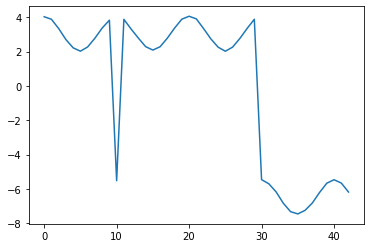

In [10]:
mp.plot(Y[:43]-Ya_unit[:43]*np.sqrt(wUnit[:43]))

In [387]:
np.sqrt(wF)

array([1.        , 1.41421356, 1.73205081, 2.        , 2.23606798,
       2.44948974, 2.64575131, 2.82842712, 3.        , 3.16227766,
       3.31662479, 3.46410162, 3.60555128, 3.74165739, 3.87298335,
       4.        , 4.12310563, 4.24264069, 4.35889894, 4.47213595,
       4.58257569, 4.69041576, 4.79583152, 4.89897949, 5.        ,
       5.09901951, 5.19615242, 5.29150262, 5.47722558, 5.47722558,
       5.47722558, 5.47722558, 5.47722558, 5.47722558, 5.47722558,
       5.47722558, 5.47722558, 5.47722558, 5.47722558, 5.47722558,
       5.47722558, 5.47722558, 5.47722558, 5.47722558, 5.47722558,
       5.47722558, 5.47722558, 5.47722558, 5.47722558, 5.47722558,
       5.47722558, 5.47722558, 5.47722558, 5.47722558, 5.47722558,
       5.47722558, 5.47722558, 5.47722558, 5.47722558, 5.47722558,
       5.47722558, 5.47722558, 5.47722558, 5.38516481, 5.29150262,
       5.19615242, 5.09901951, 5.        , 4.89897949, 4.79583152,
       4.69041576, 4.58257569, 4.47213595, 4.35889894, 4.24264

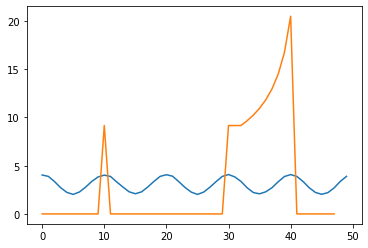

In [12]:
mp.plot(Y)
mp.plot(Ya)

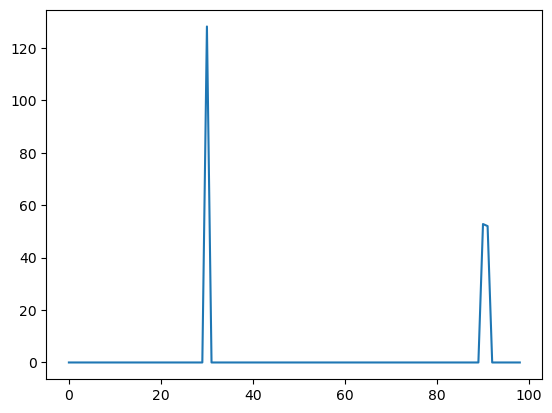

In [389]:
mp.plot(Ya_exp)

In [15]:
Ya

array([2.45989644e-16, 3.60394474e-16, 4.57287660e-16, 5.44446879e-16,
       6.36066746e-16, 7.24302226e-16, 8.14632371e-16, 9.08005116e-16,
       1.00781378e-15, 1.11240117e-15, 1.22428029e-15, 1.34690260e-15,
       1.47914129e-15, 1.62231014e-15, 1.78260231e-15, 1.96082424e-15,
       2.16578274e-15, 2.39975040e-15, 2.66871583e-15, 2.97927831e-15,
       3.35933667e-15, 3.81009059e-15, 4.37296138e-15, 5.10055527e-15,
       6.04663560e-15, 7.39712847e-15, 9.34449924e-15, 1.26111300e-14,
       1.92323430e-14, 3.65511229e-14, 1.09114993e+02, 1.09114993e+02,
       1.34571575e-15, 1.34571575e-15, 1.34571575e-15, 1.34571575e-15,
       1.34571575e-15, 1.34571575e-15, 1.34571575e-15, 1.34571575e-15,
       1.34571575e-15, 1.34571575e-15, 1.34571575e-15, 1.34571575e-15,
       1.34571575e-15, 1.34571575e-15, 1.34571575e-15, 1.34571575e-15,
       1.34571575e-15, 1.34571575e-15, 1.34571575e-15, 1.34571575e-15,
       1.34571575e-15, 1.34571575e-15, 1.34571575e-15, 1.34571575e-15,
      

In [181]:
yarr = Ya[Ya <= 1]

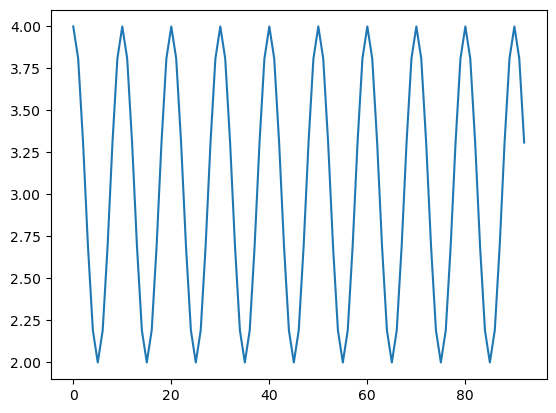

In [16]:
mp.plot(Ftotrans)

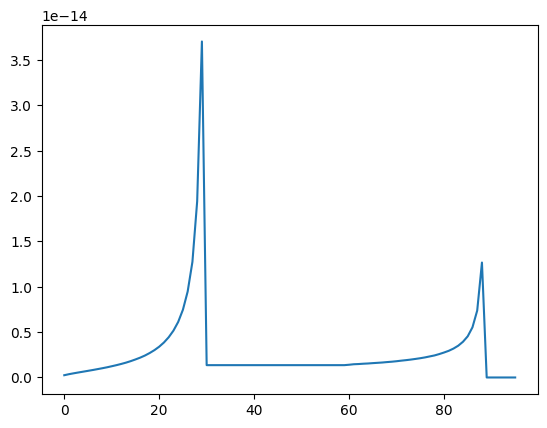

In [182]:
mp.plot(yarr)

In [69]:
py.solve()

1.9698957530675786e-15

In [58]:
py.get_problem_data()

<bound method Problem.get_problem_data of Problem(Minimize(Expression(CONVEX, NONNEGATIVE, ())), [Inequality(Expression(CONVEX, NONNEGATIVE, ()))])>

In [21]:
for variable in py.variables():
    print("Variable %s: value %s" % (variable.name(), variable.value))

Variable var604: value [-6.24292487e-18  7.62029377e-18  9.38831299e-18  2.81368852e-17
 -7.47598925e-18 -1.71346706e-17 -9.91142721e-18 -4.25978451e-17
  1.00773243e-17 -2.16415672e-17  4.67093306e-01  6.47606057e-18
  6.47606057e-18  6.47606057e-18  6.47606057e-18  6.47606057e-18
  6.47606057e-18  6.47606057e-18  6.47606057e-18  6.47606057e-18
  6.47606057e-18 -1.57881046e-17 -6.82543749e-17 -6.51156540e-17
  2.84015925e-17 -6.15165077e-17 -2.89194273e-17  7.74284846e-17
 -8.03580094e-18 -8.42719044e-17  7.38539354e-01  8.52791786e-01
  1.04445236e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [31]:
val = py.variables()[0].value

In [5]:
def defulmain(
    s,
    N,
    sigma=0.1,
    N_sim=1,
    L=10, # L =rows and k =colums n is size m is missing 
    k=2,
    m = 15,
    ):
    Ya = []
    Ya_unit = []
    Ya_exp = []
    last = len(Y)-m
    X=hmat(Y[:last],L)
    wF=froweights(L,X.shape[1])
    wUnit=np.ones(N-m)
    wExp = []
    for i in range(1,N-m):
        wExp.append(1.03**i)
    wExp=np.array(wExp)
    end = len(Y)
    Ftotrans = Y[:end-m]
    Ftohankav = lra(X,k)
    Ftonorm = hankvec_avg(Ftohankav)-Ftotrans.transpose()
    Ftosqrt = wvnorm(Ftonorm,wF)
    tauF=sqrt(Ftosqrt)
    tauUnit=sqrt(wvnorm(hankvec_avg(lra(X,k))-Y[1:end-m].transpose(),wUnit))
    tauExp=sqrt(wvnorm(hankvec_avg(lra(X,k))-Y[1:end-m].transpose(),wExp))
    print("F",tauF,tauUnit,tauExp)
    Ya=mcwf(Ftotrans.transpose(),L,m,wF,tauF)
    a_unit=mcwf(Y[1:end-m].transpose(),L,m,wUnit,tauUnit)
    Ya_exp=mcwf(Y[1:end-m].transpose(),L,m,wExp,tauExp)
    return Ya


In [10]:
    L,K = X.shape

In [11]:
f = froweights(35,26)
print(f,"with len=",len(f))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2] with len= 60


In [12]:
hankvec_avg(Ftohankav)

(35, 26) 35


array([-1.72526056, -1.41977357, -0.95209992, -0.44292458,  0.00309627,
        0.3003398 ,  0.4168693 ,  0.3662137 ,  0.20540483,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [13]:
Ftotrans

array([ 1.02608668,  0.90273276,  0.35833229, -0.24725901, -0.7128331 ,
       -0.98409911, -0.73136518, -0.23717185,  0.39730732,  0.84561357,
        1.02519395,  0.82854719,  0.31993176, -0.24533749, -0.73864638,
       -0.93313253, -0.72530742, -0.28376255,  0.3419647 ,  0.88535568,
        1.07315674,  0.83816266,  0.31714444, -0.24935829, -0.78821047,
       -0.91776488, -0.77106501, -0.26926684,  0.31976254,  0.89067049,
        1.02094298,  0.85587736,  0.30999459, -0.21576906, -0.77113754])

In [14]:
Yapp = [None]*4

In [15]:
Yapp

[None, None, None, None]

In [52]:
Yapp

Variable((50, 30))

In [65]:
N=len(Y);
#cvx_begin sdp;
#variable Yapp(N+M);
e = 1.07
lenf = len(wF)
Yapp = cp.Variable([N,lenf])
objective = cp.Minimize(cp.normNuc(Yapp))
constraints = [cp.norm((Y[:lenf]-Yapp[:lenf])) <= e]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#return result

In [67]:
result

0.0

In [91]:
np.sqrt(wF).shape

(33,)

In [93]:
(Y[:N]-x[:N]).shape

(50,)

In [57]:
cp.normNuc(scipy.linalg.hankel(x[:L],x[L:N+m])[0][0])

Expression(CONVEX, NONNEGATIVE, ())

In [56]:
scipy.linalg.hankel(x[:L])[0][0]

Expression(AFFINE, UNKNOWN, (10,))

In [58]:
scipy.linalg.hankel(x[:L])[0]

array([Expression(AFFINE, UNKNOWN, (10,))], dtype=object)

In [60]:
scipy.linalg.hankel(x[:L])

array([[Expression(AFFINE, UNKNOWN, (10,))]], dtype=object)

In [63]:
scipy.linalg.hankel(x[:L])[0]

array([Expression(AFFINE, UNKNOWN, (10,))], dtype=object)

In [64]:
x[:L]

Expression(AFFINE, UNKNOWN, (10,))

In [15]:
N=len(Y);
#cvx_begin sdp;
#%cvx_solver mosek;
#%cvx_precision low;
#Yapp = cp.Variable(N);
#objective = cp.Minimize(cp.normNuc(scipy.linalg.hankel(Yapp[:L],Yapp[L:N])[0][0]))
#constraints = cp.norm(np.sqrt(wF) @ (Y-Yapp)) <=e 
#prob = cp.Problem(objective, constraints)
#result = prob.solve()
#return result

In [11]:
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(x))
constraints = [0 <= x]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
N=len(Y)
Yapp = cp.Variable(N)
objective = cp.Minimize(cp.normNuc(cphanker(Yapp[:L],Yapp[L:N])))
constraints = cp.norm(sqrt[w]*(Y-Yapp)) <=e 
prob = cp.Problem(objective, constraints)
result = prob.solve()
return result

[array([Expression(AFFINE, UNKNOWN, (10,)),
       Expression(AFFINE, UNKNOWN, (10,))], dtype=object), array([Expression(AFFINE, UNKNOWN, (9,)),
       Expression(AFFINE, UNKNOWN, (11,))], dtype=object), array([Expression(AFFINE, UNKNOWN, (8,)),
       Expression(AFFINE, UNKNOWN, (12,))], dtype=object), array([Expression(AFFINE, UNKNOWN, (7,)),
       Expression(AFFINE, UNKNOWN, (13,))], dtype=object), array([Expression(AFFINE, UNKNOWN, (6,)),
       Expression(AFFINE, UNKNOWN, (14,))], dtype=object), array([Expression(AFFINE, UNKNOWN, (5,)),
       Expression(AFFINE, UNKNOWN, (15,))], dtype=object), array([Expression(AFFINE, UNKNOWN, (4,)),
       Expression(AFFINE, UNKNOWN, (16,))], dtype=object), array([Expression(AFFINE, UNKNOWN, (3,)),
       Expression(AFFINE, UNKNOWN, (17,))], dtype=object), array([Expression(AFFINE, UNKNOWN, (2,)),
       Expression(AFFINE, UNKNOWN, (18,))], dtype=object), array([Expression(AFFINE, UNKNOWN, (1,)),
       Expression(AFFINE, UNKNOWN, (19,))], dty

NameError: name 'w' is not defined

In [35]:
slh = scipy.linalg.hankel(Y[:L],Y[L:N])

In [32]:
scipy.linalg.hankel(Yapp[:L],Yapp[L:N])

array([[Expression(AFFINE, UNKNOWN, (5,))]], dtype=object)

In [42]:
Y[:L].shape

(5,)

In [43]:
Y[L:N].shape

(10,)

In [108]:
row = Y[:L]
reman = Y[L:N]

In [72]:
row = np.array([1,2,3])
reman = np.array([9,8,7,6,5])

In [73]:
scipy.linalg.hankel

array([[1, 2, 3, 8, 7],
       [2, 3, 8, 7, 6],
       [3, 8, 7, 6, 5]])

In [74]:
slh.shape

(5, 10)

In [115]:
def hanker(row,reman):
    hank = []
    xi = row.shape[0]
    for i in range(xi):
        hank.append(np.append(row[:xi-i],reman[1:xi+i+1]))
    return np.array(hank)

In [128]:
f = hanker(Yapp[:L],Yapp[L:N])

In [122]:
scipy.linalg.hankel(Yapp[:L],Yapp[L:N])

array([[Expression(AFFINE, UNKNOWN, (5,))]], dtype=object)

In [8]:
def cphanker(row,reman):
    hank = []
    xi = row.shape[0]
    for i in range(xi):
        hank.append(np.append(row[:xi-i],reman[1:xi+i+1]))
    print(hank)
    return cp.bmat(hank)

In [130]:
cp.bmat(f)zzzz

Expression(AFFINE, UNKNOWN, (5, 10))